<a href="https://colab.research.google.com/github/NicoG2023/Data_Science_Final_Project/blob/Predata/src/data-science-project/data_science_project/notebooks/EDA_Rain.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# EDA "Grupo Bimbo Inventory Demand"

### Introduction

Grupo Bimbo, a leading multinational bakery company, faces a unique challenge in managing the inventory of its products. With a typical shelf life of just one week, the accuracy of daily inventory calculations is paramount. Currently, these calculations are performed by direct delivery sales employees who rely on their personal experiences to predict the forces of supply, demand, and consumer behavior at each store. The margin for error in this process is minimal. Underestimating demand results in empty shelves and lost sales, while overestimating demand leads to excess product returns and increased expenses.

Grupo Bimbo aims to create a predictive model that can accurately forecast inventory needs based on historical data, thereby optimizing the supply chain and improving efficiency.


## Libraries

In [1]:
# importing the basic libraries
#!pip install ydata_profiling
# !pip install catboost
# !pip install lightgbm
# !pip install xgboost
# !pip install plotly
# !pip install path
from ydata_profiling import ProfileReport
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
# from sklearn.metrics import roc_auc_score, accuracy_score
# from sklearn.preprocessing import LabelEncoder
# from sklearn.metrics import accuracy_score
# from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
# from sklearn.linear_model import LogisticRegression
# from sklearn.svm import SVC
# from sklearn.neighbors import KNeighborsClassifier
# from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier
# from xgboost import XGBClassifier
# from lightgbm import LGBMClassifier
# from catboost import CatBoostClassifier
# import path
import os
# import plotly.express as px
import gc

## Charge data

In [2]:

train_df = pd.read_csv("../Data/train/train.csv",nrows=1000)
client_df = pd.read_csv("../Data/cliente_tabla.csv")
products_df = pd.read_csv("../Data/producto_tabla.csv")
#test_df = pd.read_csv("../Data/test/test.csv")
town_state_df = pd.read_csv("../Data/town_state.csv")

In [ ]:
# Inspect the data, with funcion

def inspect_columns(df:pd.DataFrame, df_name:str)->None:
    """
    A helper function that does a deep analisis about the columns in a dataframe
    Inputs:
     df(pd.Dataframe): the dataframe that will be inspected
     df_name(str): the tittle that will be put in the output(print) of the function
    Returns:
     None
    """

    total_rows = len(df)
    result = pd.DataFrame({
        'total_rows': [total_rows] * df.shape[1],
        'rows_with_missing_values': df.isnull().sum(),
        'unique': df.nunique() == total_rows,
        'cardinality': df.nunique(),
        'with_null': df.isna().any(),
        'null_pct': round((df.isnull().sum() / total_rows) * 100, 2),
        '1st_row': df.iloc[0],
        'random_row': df.iloc[np.random.randint(low=0, high=total_rows)],
        'last_row': df.iloc[-1],
        'dtype': df.dtypes,
    })

    # Print the name of the dataframe
    print(f"\n{'='*10} {df_name} {'='*10}\n")

    # Print the head of the dataframe
    print("First few rows of the dataframe:\n")
    display(df.head())

    # Print the resulting statistics
    print("Detailed statistics:\n")
    display(result)

## Understand the data

We performed a preliminary exploration to understand the structure of the data.

In [ ]:
inspect_columns(train_df,"Training Dataframe")
inspect_columns(client_df,"Client Dataframe")
inspect_columns(products_df,"Products Dataframe")
inspect_columns(test_df,"Test Dataframe")
inspect_columns(town_state_df,"Town and State Dataframe")

### Exploratory data analysis


In [3]:
# transform by merge with the data

train_df = train_df.merge(client_df,on = "Cliente_ID",how="left")
train_df = train_df.merge(products_df,on = "Producto_ID",how="left")
train_df = train_df.merge(town_state_df,on = "Agencia_ID",how="left")

train_df.head()

,Semana,Agencia_ID,Canal_ID,Ruta_SAK,Cliente_ID,Producto_ID,Venta_uni_hoy,Venta_hoy,Dev_uni_proxima,Dev_proxima,Demanda_uni_equil,NombreCliente,NombreProducto,Town,State
0,3,1110,7,3301,15766,1212,3,25.14,0,0.0,3,PUESTO DE PERIODICOS LAZARO,Roles Canela 2p 120g BIM 1212,2008 AG. LAGO FILT,"MÉXICO, D.F."
1,3,1110,7,3301,15766,1216,4,33.52,0,0.0,4,PUESTO DE PERIODICOS LAZARO,Roles Glass 2p 135g BIM 1216,2008 AG. LAGO FILT,"MÉXICO, D.F."
2,3,1110,7,3301,15766,1238,4,39.32,0,0.0,4,PUESTO DE PERIODICOS LAZARO,Panquecito Gota Choc 2p 140g BIM 1238,2008 AG. LAGO FILT,"MÉXICO, D.F."
3,3,1110,7,3301,15766,1240,4,33.52,0,0.0,4,PUESTO DE PERIODICOS LAZARO,Mantecadas Vainilla 4p 125g BIM 1240,2008 AG. LAGO FILT,"MÉXICO, D.F."
4,3,1110,7,3301,15766,1242,3,22.92,0,0.0,3,PUESTO DE PERIODICOS LAZARO,Donitas Espolvoreadas 6p 105g BIM 1242,2008 AG. LAGO FILT,"MÉXICO, D.F."


In [4]:
# translate the language used for the data

train_df = train_df.rename({'Semana':'Week', 'Agencia_ID':'Sales_Depot_ID', 'Canal_ID':'Sales_Channel_ID', 'Ruta_SAK':'Route_ID', 'Cliente_ID':'Client_ID',
       'Producto_ID':'Product_ID', 'Venta_uni_hoy':'Sales_unit_this_week', 'Venta_hoy':'Sales_this_week', 'Dev_uni_proxima':'Returns_unit_next_week',
       'Dev_proxima':'Returns_next_week', 'Demanda_uni_equil':'Adjusted_Demand', 'NombreCliente':'Client_name', 'NombreProducto':'Product_Name',
       'Town':'Town', 'State':'State'},axis=1)

train_df.head()

,Week,Sales_Depot_ID,Sales_Channel_ID,Route_ID,Client_ID,Product_ID,Sales_unit_this_week,Sales_this_week,Returns_unit_next_week,Returns_next_week,Adjusted_Demand,Client_name,Product_Name,Town,State
0,3,1110,7,3301,15766,1212,3,25.14,0,0.0,3,PUESTO DE PERIODICOS LAZARO,Roles Canela 2p 120g BIM 1212,2008 AG. LAGO FILT,"MÉXICO, D.F."
1,3,1110,7,3301,15766,1216,4,33.52,0,0.0,4,PUESTO DE PERIODICOS LAZARO,Roles Glass 2p 135g BIM 1216,2008 AG. LAGO FILT,"MÉXICO, D.F."
2,3,1110,7,3301,15766,1238,4,39.32,0,0.0,4,PUESTO DE PERIODICOS LAZARO,Panquecito Gota Choc 2p 140g BIM 1238,2008 AG. LAGO FILT,"MÉXICO, D.F."
3,3,1110,7,3301,15766,1240,4,33.52,0,0.0,4,PUESTO DE PERIODICOS LAZARO,Mantecadas Vainilla 4p 125g BIM 1240,2008 AG. LAGO FILT,"MÉXICO, D.F."
4,3,1110,7,3301,15766,1242,3,22.92,0,0.0,3,PUESTO DE PERIODICOS LAZARO,Donitas Espolvoreadas 6p 105g BIM 1242,2008 AG. LAGO FILT,"MÉXICO, D.F."


In [5]:
train_df['Week'] = train_df['Week'].astype('int8')
train_df['Sales_Depot_ID'] = train_df['Sales_Depot_ID'].astype('int16')
train_df['Sales_Channel_ID'] = train_df['Sales_Channel_ID'].astype('int8')
train_df['Route_ID'] = train_df['Route_ID'].astype('int16')
train_df['Client_ID'] = train_df['Client_ID'].astype('int32')
train_df['Product_ID'] = train_df['Product_ID'].astype('int32')
train_df['Sales_unit_this_week'] = train_df['Sales_unit_this_week'].astype('int16')
train_df['Returns_unit_next_week'] = train_df['Returns_unit_next_week'].astype('int32')
train_df['Adjusted_Demand'] = train_df['Adjusted_Demand'].astype('int32')

print(train_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1025 entries, 0 to 1024
Data columns (total 15 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Week                    1025 non-null   int8   
 1   Sales_Depot_ID          1025 non-null   int16  
 2   Sales_Channel_ID        1025 non-null   int8   
 3   Route_ID                1025 non-null   int16  
 4   Client_ID               1025 non-null   int32  
 5   Product_ID              1025 non-null   int32  
 6   Sales_unit_this_week    1025 non-null   int16  
 7   Sales_this_week         1025 non-null   float64
 8   Returns_unit_next_week  1025 non-null   int32  
 9   Returns_next_week       1025 non-null   float64
 10  Adjusted_Demand         1025 non-null   int32  
 11  Client_name             1025 non-null   object 
 12  Product_Name            1025 non-null   object 
 13  Town                    1025 non-null   object 
 14  State                   1025 non-null   

# Web Scraping

According to the dataset, the data was taken in a timespan of 9 weeks. It's been decided to get the biweekly inflation and the consumer confidence index from Mexico. The info was taken from March 31st, 2016, until June 1st, 2016.

In [6]:
#Getting biweekly inflation
import sys
import requests
from datetime import datetime

api_key = '74bcad49-835f-fab1-c9f0-fdab92570186'

api_url = f'https://www.inegi.org.mx/app/api/indicadores/desarrolladores/jsonxml/INDICATOR/628229/es/0700/false/BIE/2.0/{api_key}?type=json'

response = requests.get(api_url)
if response.status_code == 200:
    inflation_data = response.json()
else:
    print('ERROR FAILED TO RETRIEVE DATA')
    sys.exit()

observations = inflation_data['Series'][0]['OBSERVATIONS']
dates = []
values = []
for obs in observations:
    dates.append(obs['TIME_PERIOD'])
    values.append(obs['OBS_VALUE'])

inflation_df = pd.DataFrame({
    'Fecha': dates,
    'Inflacion': values
})

inflation_df['Fecha'] = pd.to_datetime(inflation_df['Fecha'], format='%Y/%m/%d')
start_date = datetime(2016, 3, 31)
end_date = datetime(2016, 6, 1)

filtered_inflation_df = inflation_df[(inflation_df['Fecha'] >= start_date) & (inflation_df['Fecha'] <= end_date)]
filtered_inflation_df = filtered_inflation_df.reset_index(drop=True)
filtered_inflation_df

,Fecha,Inflacion
0,2016-06-01,0.02
1,2016-05-02,0.17
2,2016-05-01,-0.48
3,2016-04-02,-0.09
4,2016-04-01,-0.34


In [7]:
#Getting consumer confidence index
api_key = '74bcad49-835f-fab1-c9f0-fdab92570186'
api_url = f'https://www.inegi.org.mx/app/api/indicadores/desarrolladores/jsonxml/INDICATOR/454168/es/0700/false/BIE/2.0/{api_key}?type=json'

response = requests.get(api_url)
if response.status_code == 200:
    confidence_data = response.json()
else:
    print('ERROR FAILED TO RETRIEVE DATA')
    sys.exit()

observations = confidence_data['Series'][0]['OBSERVATIONS']
dates = []
values = []

for obs in observations:
    dates.append(obs['TIME_PERIOD'])
    values.append(obs['OBS_VALUE'])

confidence_data = pd.DataFrame({
    'Fecha': dates,
    'Consumer_confidence': values
})

confidence_data['Fecha'] = pd.to_datetime(confidence_data['Fecha'], format='%Y/%m')
start_date = datetime(2016, 3, 31)
end_date = datetime(2016, 6, 1)

filtered_confidence_df = confidence_data[(confidence_data['Fecha'] >= start_date) & (confidence_data['Fecha'] <= end_date)]
filtered_confidence_df = filtered_confidence_df.reset_index(drop=True)
filtered_confidence_df

,Fecha,Consumer_confidence
0,2016-06-01,38.349095003102
1,2016-05-01,37.48480388305
2,2016-04-01,36.713858243741


## Data Merging
Having charged and understood the data now we proceed to merge it in order to create a consise and rich dataset for the model to be given 

In [8]:
# merging train_df, filtered_confidence_df, filtered_inflation_df
weeks_to_inflation_dates = {
    'Week': [1, 2, 3, 4, 5, 6, 7, 8, 9],
    'Fecha': [
        '2016-04-01','2016-04-01',
        '2016-04-02','2016-04-02',
        '2016-05-01','2016-05-01',
        '2016-05-02','2016-05-02',
        '2016-06-01'
    ]
}
inflation_weeks_df = pd.DataFrame(weeks_to_inflation_dates)
inflation_weeks_df['Fecha'] = pd.to_datetime(inflation_weeks_df['Fecha'])

weeks_to_confidence_dates = {
    'Week': [1, 2, 3, 4, 5, 6, 7, 8, 9],
    'Fecha': [
        '2016-04-01', '2016-05-01', '2016-05-01', '2016-05-01', '2016-05-01',
        '2016-06-01', '2016-06-01', '2016-06-01', '2016-06-01'
    ]
}
confidence_weeks_df = pd.DataFrame(weeks_to_confidence_dates)
confidence_weeks_df['Fecha'] = pd.to_datetime(confidence_weeks_df['Fecha'])
print(inflation_weeks_df)
print(confidence_weeks_df)


   Week      Fecha
0     1 2016-04-01
1     2 2016-04-01
2     3 2016-04-02
3     4 2016-04-02
4     5 2016-05-01
5     6 2016-05-01
6     7 2016-05-02
7     8 2016-05-02
8     9 2016-06-01
   Week      Fecha
0     1 2016-04-01
1     2 2016-05-01
2     3 2016-05-01
3     4 2016-05-01
4     5 2016-05-01
5     6 2016-06-01
6     7 2016-06-01
7     8 2016-06-01
8     9 2016-06-01


In [9]:
confidence_merged_df = pd.merge(confidence_weeks_df, filtered_confidence_df, on='Fecha', how='left')
inflation_merged_df = pd.merge(inflation_weeks_df, filtered_inflation_df, on='Fecha', how='left')
print(confidence_merged_df)
print(inflation_merged_df)

   Week      Fecha Consumer_confidence
0     1 2016-04-01     36.713858243741
1     2 2016-05-01      37.48480388305
2     3 2016-05-01      37.48480388305
3     4 2016-05-01      37.48480388305
4     5 2016-05-01      37.48480388305
5     6 2016-06-01     38.349095003102
6     7 2016-06-01     38.349095003102
7     8 2016-06-01     38.349095003102
8     9 2016-06-01     38.349095003102
   Week      Fecha Inflacion
0     1 2016-04-01     -0.34
1     2 2016-04-01     -0.34
2     3 2016-04-02     -0.09
3     4 2016-04-02     -0.09
4     5 2016-05-01     -0.48
5     6 2016-05-01     -0.48
6     7 2016-05-02      0.17
7     8 2016-05-02      0.17
8     9 2016-06-01      0.02


In [10]:
confidence_merged_df = confidence_merged_df.drop(columns=['Fecha'])
inflation_merged_df = inflation_merged_df.drop(columns=['Fecha'])
print(confidence_merged_df)
print(inflation_merged_df)

   Week Consumer_confidence
0     1     36.713858243741
1     2      37.48480388305
2     3      37.48480388305
3     4      37.48480388305
4     5      37.48480388305
5     6     38.349095003102
6     7     38.349095003102
7     8     38.349095003102
8     9     38.349095003102
   Week Inflacion
0     1     -0.34
1     2     -0.34
2     3     -0.09
3     4     -0.09
4     5     -0.48
5     6     -0.48
6     7      0.17
7     8      0.17
8     9      0.02


In [11]:
final_df = pd.merge(train_df, confidence_merged_df, on='Week', how='left')
final_df = pd.merge(final_df, inflation_merged_df, on='Week', how='left')
print(final_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1025 entries, 0 to 1024
Data columns (total 17 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Week                    1025 non-null   int8   
 1   Sales_Depot_ID          1025 non-null   int16  
 2   Sales_Channel_ID        1025 non-null   int8   
 3   Route_ID                1025 non-null   int16  
 4   Client_ID               1025 non-null   int32  
 5   Product_ID              1025 non-null   int32  
 6   Sales_unit_this_week    1025 non-null   int16  
 7   Sales_this_week         1025 non-null   float64
 8   Returns_unit_next_week  1025 non-null   int32  
 9   Returns_next_week       1025 non-null   float64
 10  Adjusted_Demand         1025 non-null   int32  
 11  Client_name             1025 non-null   object 
 12  Product_Name            1025 non-null   object 
 13  Town                    1025 non-null   object 
 14  State                   1025 non-null   

In [ ]:
final_df.head()

### Feature Engineering

In [12]:
import gc
del train_df
del client_df
del products_df
#del test_df
del town_state_df
gc.collect()

#get floats32 columns based on previus columns to feed the model 
final_df['Consumer_confidence'] = pd.to_numeric(final_df['Consumer_confidence'], errors='coerce')
final_df['Inflacion'] = pd.to_numeric(final_df['Inflacion'], errors='coerce')
final_df['Inflacion'] = final_df['Inflacion'].astype('float32')
final_df['Consumer_confidence'] = final_df['Consumer_confidence'].astype('float32')

print(final_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1025 entries, 0 to 1024
Data columns (total 17 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Week                    1025 non-null   int8   
 1   Sales_Depot_ID          1025 non-null   int16  
 2   Sales_Channel_ID        1025 non-null   int8   
 3   Route_ID                1025 non-null   int16  
 4   Client_ID               1025 non-null   int32  
 5   Product_ID              1025 non-null   int32  
 6   Sales_unit_this_week    1025 non-null   int16  
 7   Sales_this_week         1025 non-null   float64
 8   Returns_unit_next_week  1025 non-null   int32  
 9   Returns_next_week       1025 non-null   float64
 10  Adjusted_Demand         1025 non-null   int32  
 11  Client_name             1025 non-null   object 
 12  Product_Name            1025 non-null   object 
 13  Town                    1025 non-null   object 
 14  State                   1025 non-null   

In [ ]:
sample_df = final_df.sample(frac=0.2, random_state=1)
profile_obj = ProfileReport(sample_df, title='Bimbo Inventory Demand Data Profiling Report')
profile_obj.to_file('../Data/train_final_normal.html')

In [14]:
#profile_obj
final_df['Inflacion'] = final_df['Inflacion'].astype('float16')
final_df['Consumer_confidence'] = final_df['Consumer_confidence'].astype('float16')
final_df['Returns_next_week'] = final_df['Returns_next_week'].astype('float32')

print(final_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1025 entries, 0 to 1024
Data columns (total 17 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Week                    1025 non-null   int8   
 1   Sales_Depot_ID          1025 non-null   int16  
 2   Sales_Channel_ID        1025 non-null   int8   
 3   Route_ID                1025 non-null   int16  
 4   Client_ID               1025 non-null   int32  
 5   Product_ID              1025 non-null   int32  
 6   Sales_unit_this_week    1025 non-null   int16  
 7   Sales_this_week         1025 non-null   float64
 8   Returns_unit_next_week  1025 non-null   int32  
 9   Returns_next_week       1025 non-null   float32
 10  Adjusted_Demand         1025 non-null   int32  
 11  Client_name             1025 non-null   object 
 12  Product_Name            1025 non-null   object 
 13  Town                    1025 non-null   object 
 14  State                   1025 non-null   

In [15]:
#remove Object(str) columns to feed the model
final_df =final_df.drop(columns={"Client_name","Product_Name","Town","State"})

## Model Selection

In [16]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

#preprocess data -forecast "Ajusted_Demand" 
le = LabelEncoder()
final_df["Adjusted_Demand"] = le.fit_transform(final_df["Adjusted_Demand"])

#Selecting "Adjusted_Demand"
columns_to_drop = ["Adjusted_Demand"]
x = final_df.drop(columns_to_drop,axis=1) 
y = final_df["Adjusted_Demand"]

#scaling x
sc = StandardScaler()
x = sc.fit_transform(x)

#generate train and test datasets
x_final_df_train,x_final_df_test,y_final_df_train,y_final_df_test = train_test_split(x,y,test_size=0.3,random_state=42)


### Test RandomForest

In [17]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier

#creating Random forest Classifier
cl_rf = RandomForestClassifier()
#perform cross- validation
scores_rf = cross_val_score(cl_rf,x,y,cv=10)
print("Accuracy per fold: ",scores_rf)


/home/giovanny/.pyenv/versions/data-science/lib/python3.12/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(


Accuracy per fold:  [0.78640777 0.81553398 0.81553398 0.78640777 0.7961165  0.84313725
 0.73529412 0.73529412 0.79411765 0.68627451]


### Test XGB

In [19]:
import xgboost as xgb

# Creating XGB Classifier
cl_xgb =xgb.XGBRFRegressor()
#perform cross-validation
scores_xgb = cross_val_score(cl_xgb,x,y,cv=10)
print("Accuracy per fold: ",scores_xgb)



Accuracy per fold:  [0.99828702 0.99865001 0.99757892 0.99764186 0.99879962 0.99881655
 0.98488432 0.99855417 0.99791783 0.99884617]


### Models Comparison

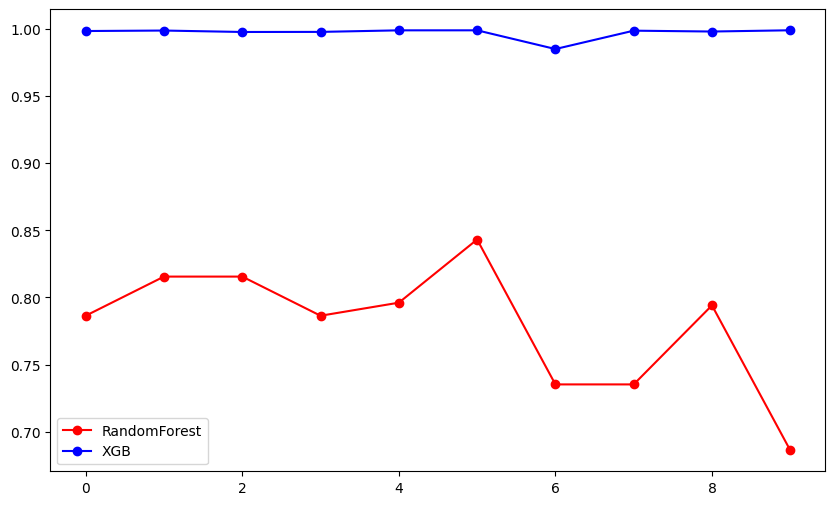

In [27]:
#Metrics
plt.figure(figsize=(10,6))
plt.plot(scores_rf,marker="o",linestyle="-",color="red",label="RandomForest")
plt.plot(scores_xgb,marker="o",linestyle="-",color="blue",label="XGB")
plt.legend()


### Model Training

In [32]:
from sklearn.metrics import mean_squared_error

# We delete the RandomForest Classifier
del cl_rf #comentar esta linea si ya se borro el objeto
# Training XGB model
cl_xgb.fit(x_final_df_train,y_final_df_train)
#calculate predictions and evaluate performance
y_hat_xgb = cl_xgb.predict(x_final_df_test)
mse = mean_squared_error(y_final_df_test,y_hat_xgb)
print("mean squared error: ",mse)

mean squared error:  0.2797820534993266
